In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
###------------------------------
### global variables
##-----------------
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)

N_SAMPLE  = 1000
NOISE = .2
ALPHA = .001 ## very small alpha is bad idea -
TEST_SIZE = .2
EPOCHS = 100000 #NO. of itersation used to optimize weights
# input and output directories

params = {'legend.fontsize' : 'medium', 
          'figure.figsize' : (15, 4),
          'axes.labelsize' : 'medium',
          'axes.titlesize' : 'large',
          'xtick.labelsize' : 'medium',
          'ytick.labelsize' : 'medium',
         }
loss_hist = {} # creating an empty dictionary which will store loss and epoch later so that we can make loss curve later

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm

# plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')

In [3]:
X, y = datasets.make_moons(n_samples = N_SAMPLE, # n_samples: how many datasets in it
                          noise = NOISE, # peportion of randommness added to data so that it matched to real life data , without noise it becomes perfect half circle in moon dataset
                          shuffle = True, 
                          random_state = RANDOM_STATE)
X.shape, y.shape

((1000, 2), (1000,))

# one hidden layer

In [5]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

In [6]:
def fn_actv(z):
    return np.tanh(z)

In [7]:
def fn_actv_prime(z):
    return 1-(np.tanh(z))**2

In [8]:
fn_actv(np.array([[-1,0,1],[-np.inf, 0, np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [9]:
def predict(model, X_p): # this function will work as activation function
    W1, b1, W2, b2= model['W1'], model['b1'], model['W2'], model['b2']
    m=X_p.shape[0]
    ## forward propagation
    #layer 1
    z1 = X_p.dot(W1) + b1  # aggregation function
    a1 = fn_actv(z1) # activation funvtion
    # Layer 2
    z2 = a1.dot(W2) + b2 # aggregation function for hidden layer
    a2 = sigmoid(z2) # activation
   
    return a2 >= 0.5

In [10]:
def fn_calculate_loss (model, X_l, y_l):
    W1, b1, W2, b2= model['W1'], model['b1'], model['W2'], model['b2']
    m=X_l.shape[0]
    ## forward propagation
    #layer 1
    z1 = X_l.dot(W1) + b1  # aggregation function
    a1 = fn_actv(z1) # activation funvtion
    # Layer 2
    z2 = a1.dot(W2) + b2 # aggregation function for hidden layer
    a2 = sigmoid(z2) # activation
    data_loss = -y_l* np.log(a2)
    return data_loss.sum()/m

In [11]:
# features_df = data_df.drop('target', axis=1)
# labels= data_df['target']

In [12]:
X_train, X_test, y_train, y_test=   train_test_split(X,y , random_state= RANDOM_STATE, stratify=y, test_size= TEST_SIZE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [13]:
rng = np.random.default_rng(seed = RANDOM_STATE)

def build_model(nn_hdim, X_t, y_t, n_epoch = EPOCHS, alpha = ALPHA): # nn_hdim:- no of hidden layers 
    '''
    2-4-1
    '''
    # get dimensions for weight in it
    m, nn_input_dim = X_t.shape # m is no of rows
    nn_output_shape = y_t.shape[1]
    # initializing weighs randomly using numoy generator
    W1 = rng.random((nn_input_dim, nn_hdim), dtype= np.float32) / np.sqrt(nn_input_dim)
    W2 = rng.random((nn_hdim, nn_output_shape), dtype = np.float32)/ np.sqrt(nn_hdim)

    # initializing bias 
    b1 = np.zeros((1, nn_hdim), dtype = np.float32)
    b2 = np.zeros((1, nn_output_shape), dtype = np.float32)

    curr_loss = 0
    loss = []
    epoch = []
    for i in range(n_epoch):
        ## forward propagation
        #layer 1
        z1 = X_t.dot(W1) + b1  # aggregation function
        a1 = fn_actv(z1) # activation funvtion
        # Layer 2
        z2 = a1.dot(W2) + b2 # aggregation function for hidden layer
        a2 = sigmoid(z2) # activation

        ## backpropagation
        # print(y.shape)
        dz2 = a2 - y_t # y should be of shape (1, m)
        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), f'Shape: W2-{W2.shape} and dw2-{dW2.shape}'

        db2 = np.sum(dz2, axis = 0, keepdims = True)
        assert (b2.shape == db2.shape), f'Shape: b2-{b2.shape} and db2-{db2.shape}'
        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), f'Shape: a1-{a1.shape} and da1-{da1.shape}'

        # layer 1
        dz1 = da1 * fn_actv_prime(z1)
        assert (z1.shape == dz1.shape), f'Shape: z1-{z1.shape} and dz1-{dz1.shape}'
        dW1 = (X_t.T).dot(dz1)
        assert (W1.shape== dW1.shape), f'Shape: W1-{W1.shape} and dW1-{dW1.shape}'
        db1= np.sum(dz1, axis=0, keepdims=True)
        assert (b1.shape== db1.shape), f'Shape: b1-{b1.shape} and db1-{db1.shape}'

        #### Gradient Updates

        W1 += - alpha *dW1/m
        W2 += - alpha *dW2/m
        b1 += - alpha *db1/m
        b2 += - alpha *db2/m
        model = {'W1':W1, 'b1': b1, 'W2': W2, 'b2' : b2}

        if i%100 == 0:
            curr_loss = fn_calculate_loss(model, X_t, y_t)
            loss.append(curr_loss)
            epoch.append(i)
            
        if i%1000 == 0:
            print(f'Loss after {i:>5d} epochs : {curr_loss:0.5f}')


    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss

    return model
            

In [14]:
model  = build_model(4, X_train, y_train.reshape(-1,1));

Loss after     0 epochs : 0.29116
Loss after  1000 epochs : 0.29453
Loss after  2000 epochs : 0.29366
Loss after  3000 epochs : 0.28927
Loss after  4000 epochs : 0.28231
Loss after  5000 epochs : 0.27376
Loss after  6000 epochs : 0.26447
Loss after  7000 epochs : 0.25504
Loss after  8000 epochs : 0.24586
Loss after  9000 epochs : 0.23715
Loss after 10000 epochs : 0.22900
Loss after 11000 epochs : 0.22143
Loss after 12000 epochs : 0.21442
Loss after 13000 epochs : 0.20796
Loss after 14000 epochs : 0.20202
Loss after 15000 epochs : 0.19657
Loss after 16000 epochs : 0.19158
Loss after 17000 epochs : 0.18704
Loss after 18000 epochs : 0.18292
Loss after 19000 epochs : 0.17919
Loss after 20000 epochs : 0.17583
Loss after 21000 epochs : 0.17282
Loss after 22000 epochs : 0.17013
Loss after 23000 epochs : 0.16773
Loss after 24000 epochs : 0.16560
Loss after 25000 epochs : 0.16371
Loss after 26000 epochs : 0.16205
Loss after 27000 epochs : 0.16057
Loss after 28000 epochs : 0.15928
Loss after 290

In [15]:
y_pred = predict(model, X_train)
accuracy_score(y_train, y_pred)

0.875

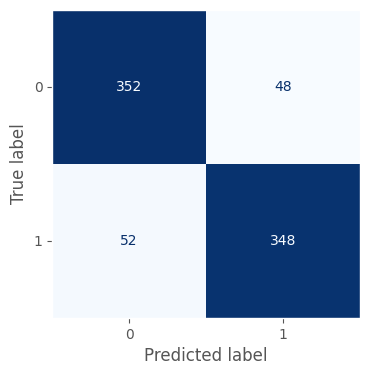

In [16]:
cm = confusion_matrix(y_train, y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0,1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

In [17]:
y_pred = predict(model, X_test)
accuracy_score(y_test, y_pred)

0.855

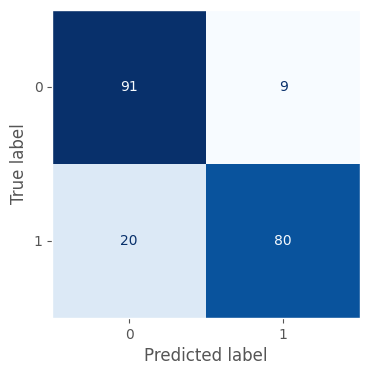

In [18]:
cm = confusion_matrix(y_test, y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

<Axes: xlabel='epoch'>

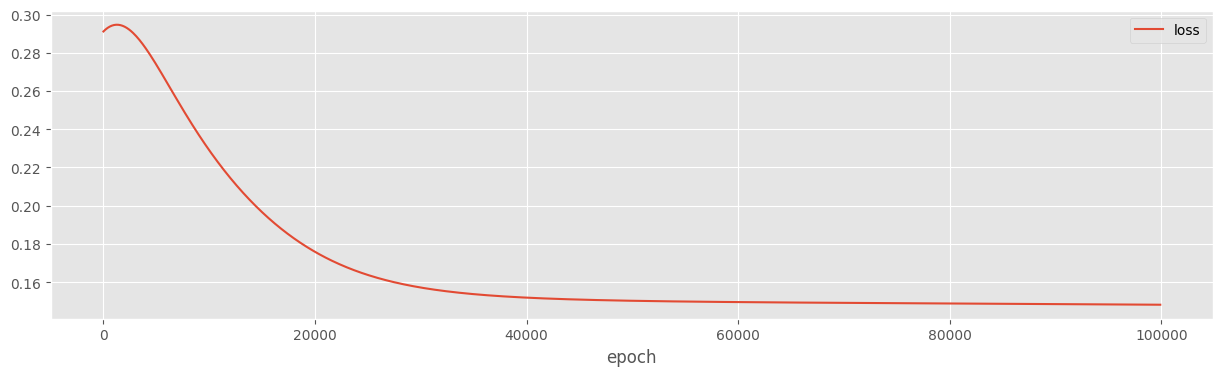

In [19]:
pd.DataFrame(loss_hist).plot(x= 'epoch', y = 'loss')

In [20]:
def fn_plot_decision_boundry(model, X, y, X_ts, y_ts): # x, y are trainig data, X_ts, y_ts are test data
    fig, ax = plt.subplots(figsize =(8,5))
    dm=0.01 # spacing of the grid width
    
    #Min and max along two axis
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()

    # generate a mesh grid
    xx,yy = np.meshgrid(np.arange(x_min, x_max, dm), # creates an array of x-cordinates y no of times
                       np.arange(y_min, y_max, dm)) # creates an array of y-cordinates x no of times
    # Together they create a mesh\
    
    XX = np.c_[xx.ravel(), yy.ravel()]
    
    y_pred= predict(model, XX)

    
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx,yy, Z, alpha=0.8, cmap= plt.cm.Paired)
    ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap= CMAP)
    ax.scatter(X_ts[:,0], X_ts[:,1], c = y_ts, edgecolors='k', cmap= CMAP,marker='*')

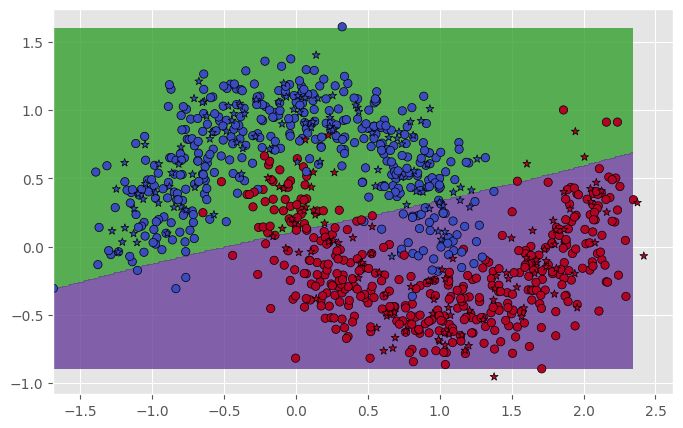

In [21]:
fn_plot_decision_boundry(model, X_train, y_train, X_test, y_test)

# with one neuron in hidden layer

In [23]:
model  = build_model(1, X_train, y_train.reshape(-1,1));

Loss after     0 epochs : 0.32690
Loss after  1000 epochs : 0.32990
Loss after  2000 epochs : 0.33138
Loss after  3000 epochs : 0.33124
Loss after  4000 epochs : 0.32954
Loss after  5000 epochs : 0.32637
Loss after  6000 epochs : 0.32188
Loss after  7000 epochs : 0.31621
Loss after  8000 epochs : 0.30957
Loss after  9000 epochs : 0.30218
Loss after 10000 epochs : 0.29429
Loss after 11000 epochs : 0.28616
Loss after 12000 epochs : 0.27798
Loss after 13000 epochs : 0.26989
Loss after 14000 epochs : 0.26197
Loss after 15000 epochs : 0.25425
Loss after 16000 epochs : 0.24676
Loss after 17000 epochs : 0.23950
Loss after 18000 epochs : 0.23248
Loss after 19000 epochs : 0.22573
Loss after 20000 epochs : 0.21927
Loss after 21000 epochs : 0.21314
Loss after 22000 epochs : 0.20737
Loss after 23000 epochs : 0.20198
Loss after 24000 epochs : 0.19700
Loss after 25000 epochs : 0.19242
Loss after 26000 epochs : 0.18825
Loss after 27000 epochs : 0.18446
Loss after 28000 epochs : 0.18106
Loss after 290

In [24]:
y_pred = predict(model, X_train)
accuracy_score(y_train, y_pred)

0.87375

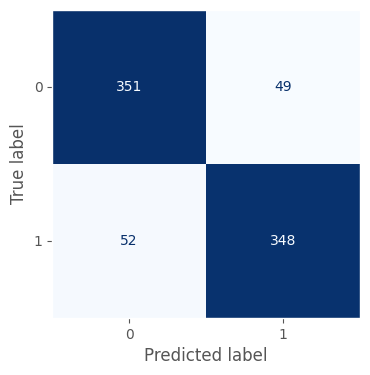

In [25]:
cm = confusion_matrix(y_train, y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0,1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

In [26]:
y_pred = predict(model, X_test)
accuracy_score(y_test, y_pred)

0.855

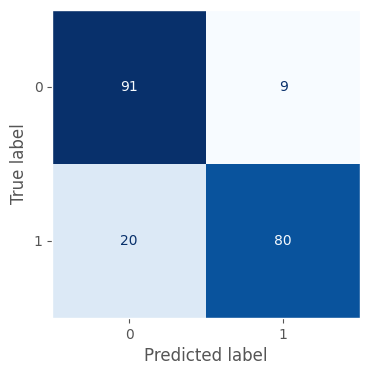

In [27]:
cm = confusion_matrix(y_test, y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

<Axes: xlabel='epoch'>

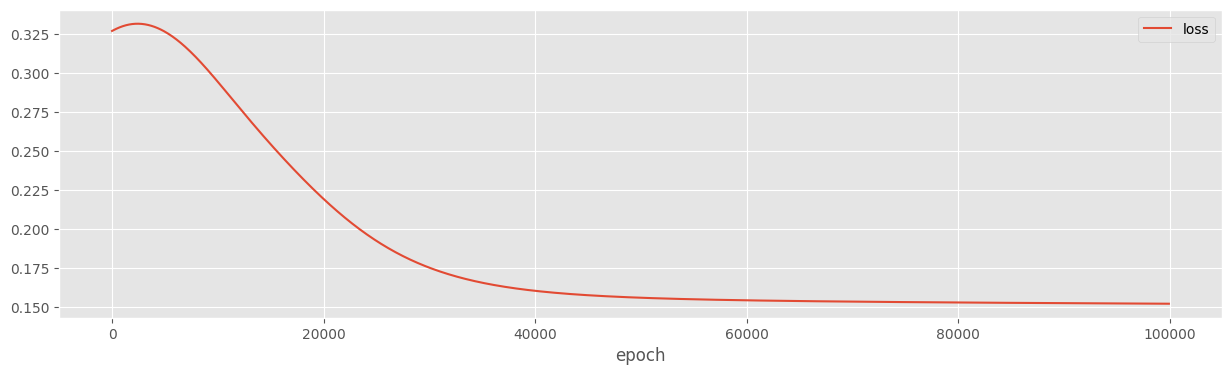

In [28]:
pd.DataFrame(loss_hist).plot(x= 'epoch', y = 'loss')

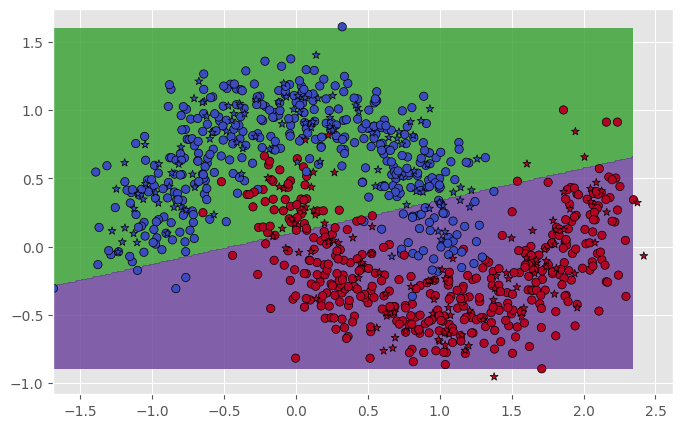

In [29]:
fn_plot_decision_boundry(model, X_train, y_train, X_test, y_test)

# with 10 neurons in hidden layer

In [31]:
model  = build_model(10, X_train, y_train.reshape(-1,1));

Loss after     0 epochs : 0.27263
Loss after  1000 epochs : 0.27861
Loss after  2000 epochs : 0.27665
Loss after  3000 epochs : 0.26907
Loss after  4000 epochs : 0.25810
Loss after  5000 epochs : 0.24581
Loss after  6000 epochs : 0.23379
Loss after  7000 epochs : 0.22296
Loss after  8000 epochs : 0.21360
Loss after  9000 epochs : 0.20565
Loss after 10000 epochs : 0.19886
Loss after 11000 epochs : 0.19301
Loss after 12000 epochs : 0.18791
Loss after 13000 epochs : 0.18340
Loss after 14000 epochs : 0.17939
Loss after 15000 epochs : 0.17581
Loss after 16000 epochs : 0.17260
Loss after 17000 epochs : 0.16972
Loss after 18000 epochs : 0.16714
Loss after 19000 epochs : 0.16484
Loss after 20000 epochs : 0.16278
Loss after 21000 epochs : 0.16095
Loss after 22000 epochs : 0.15932
Loss after 23000 epochs : 0.15787
Loss after 24000 epochs : 0.15658
Loss after 25000 epochs : 0.15544
Loss after 26000 epochs : 0.15444
Loss after 27000 epochs : 0.15354
Loss after 28000 epochs : 0.15275
Loss after 290

In [32]:
y_pred = predict(model, X_train)
accuracy_score(y_train, y_pred)

0.8875

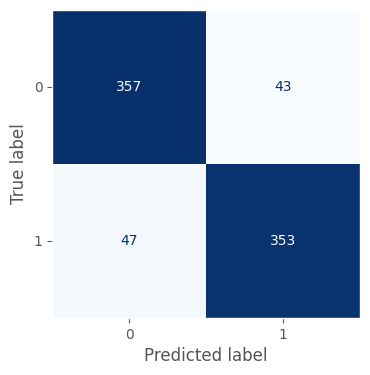

In [33]:
cm = confusion_matrix(y_train, y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0,1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

In [34]:
y_pred = predict(model, X_test)
accuracy_score(y_test, y_pred)

0.9

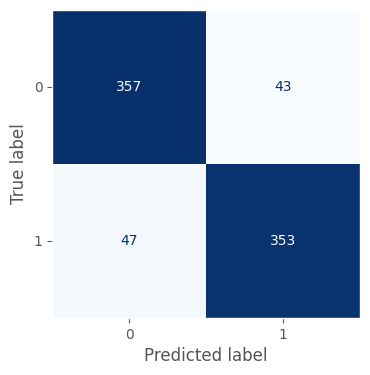

In [35]:
plost = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

<Axes: xlabel='epoch'>

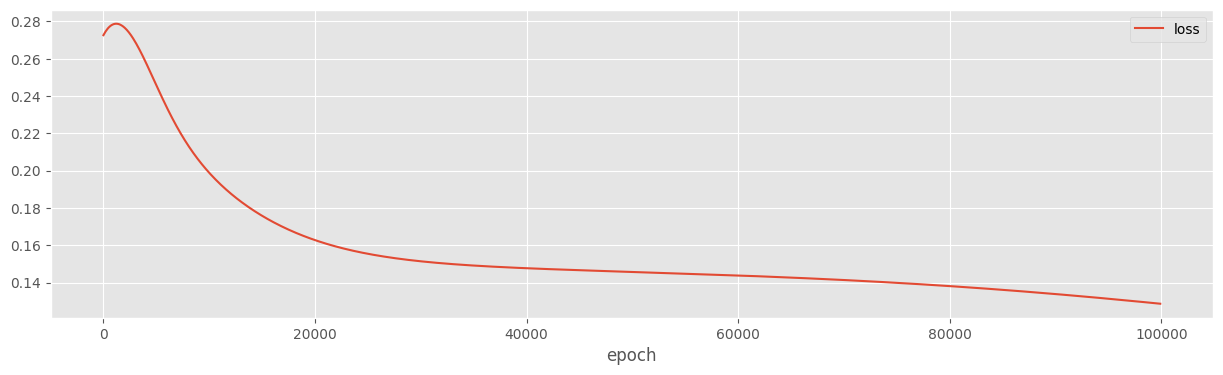

In [36]:
pd.DataFrame(loss_hist).plot(x= 'epoch', y = 'loss')

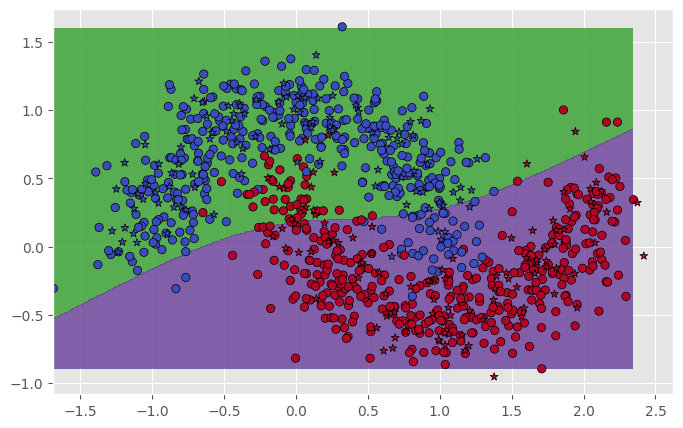

In [37]:
fn_plot_decision_boundry(model, X_train, y_train, X_test, y_test)

# with 50 neurons in hidden layer

In [ ]:
model  = build_model(50, X_train, y_train.reshape(-1,1));

Loss after     0 epochs : 0.19778
Loss after  1000 epochs : 0.25308
Loss after  2000 epochs : 0.25006
Loss after  3000 epochs : 0.23263
Loss after  4000 epochs : 0.21648
Loss after  5000 epochs : 0.20364
Loss after  6000 epochs : 0.19369
Loss after  7000 epochs : 0.18593
Loss after  8000 epochs : 0.17979
Loss after  9000 epochs : 0.17485
Loss after 10000 epochs : 0.17082
Loss after 11000 epochs : 0.16749
Loss after 12000 epochs : 0.16470
Loss after 13000 epochs : 0.16236
Loss after 14000 epochs : 0.16037
Loss after 15000 epochs : 0.15868
Loss after 16000 epochs : 0.15723
Loss after 17000 epochs : 0.15597
Loss after 18000 epochs : 0.15489
Loss after 19000 epochs : 0.15395
Loss after 20000 epochs : 0.15313
Loss after 21000 epochs : 0.15241
Loss after 22000 epochs : 0.15177
Loss after 23000 epochs : 0.15121
Loss after 24000 epochs : 0.15071
Loss after 25000 epochs : 0.15027
Loss after 26000 epochs : 0.14987
Loss after 27000 epochs : 0.14951
Loss after 28000 epochs : 0.14918


In [ ]:
y_pred = predict(model, X_train)
accuracy_score(y_train, y_pred)

In [ ]:
cm = confusion_matrix(y_train, y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0,1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

In [ ]:
y_pred = predict(model, X_test)
accuracy_score(y_test, y_pred)

In [ ]:
plost = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

In [ ]:
pd.DataFrame(loss_hist).plot(x= 'epoch', y = 'loss')

In [ ]:
fn_plot_decision_boundry(model, X_train, y_train, X_test, y_test)